In [2]:
import scanpy as sc
import surgeon
import numpy as np
sc.settings.set_figure_params(dpi=200, frameon=False)

Using TensorFlow backend.


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)

In [4]:
condition_key = "Method"
cell_type_key = 'CellType'
target_condition = "Drop-seq"

# Loading 6 PBMC datasets and data preparation

In [31]:
adata_pbmc_bbknn.X.max()

8.5225315

In [14]:
adata_6_tech = sc.read("./data/PBMC//broad_pbmc_count.h5ad")
adata_pbmc_bbknn = sc.read("./data/PBMC//bbknn_pbmc_raw.h5ad")
adata_pbmc_68k = sc.read("./data/PBMC/pbmc_68k.h5ad")
adata_small_3k = sc.read("./data/PBMC/pbmc3k.h5ad")
adata_small_3k = sc.AnnData(adata_small_3k.raw.X, var=adata_small_3k.raw.var, obs=adata_small_3k.obs) 

In [27]:
adata = sc.AnnData.concatenate(adata_6_tech,adata_pbmc_bbknn,adata_pbmc_68k,adata_small_3k)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


## Normalize PBMC dataset & select top HVGs

In [5]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)

In [7]:
adata = adata[:, adata.var['highly_variable']]

In [8]:
adata

View of AnnData object with n_obs × n_vars = 20555 × 1000 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts'
    var: 'ENS', 'Name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [9]:
adata.obs[condition_key].value_counts()

inDrops              6584
Drop-seq             6584
10x Chromium V2 B    3222
10x Chromium V2 A    3222
Smart-seq2            526
CEL-Seq2              417
Name: Method, dtype: int64

## visualization  of the original data

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


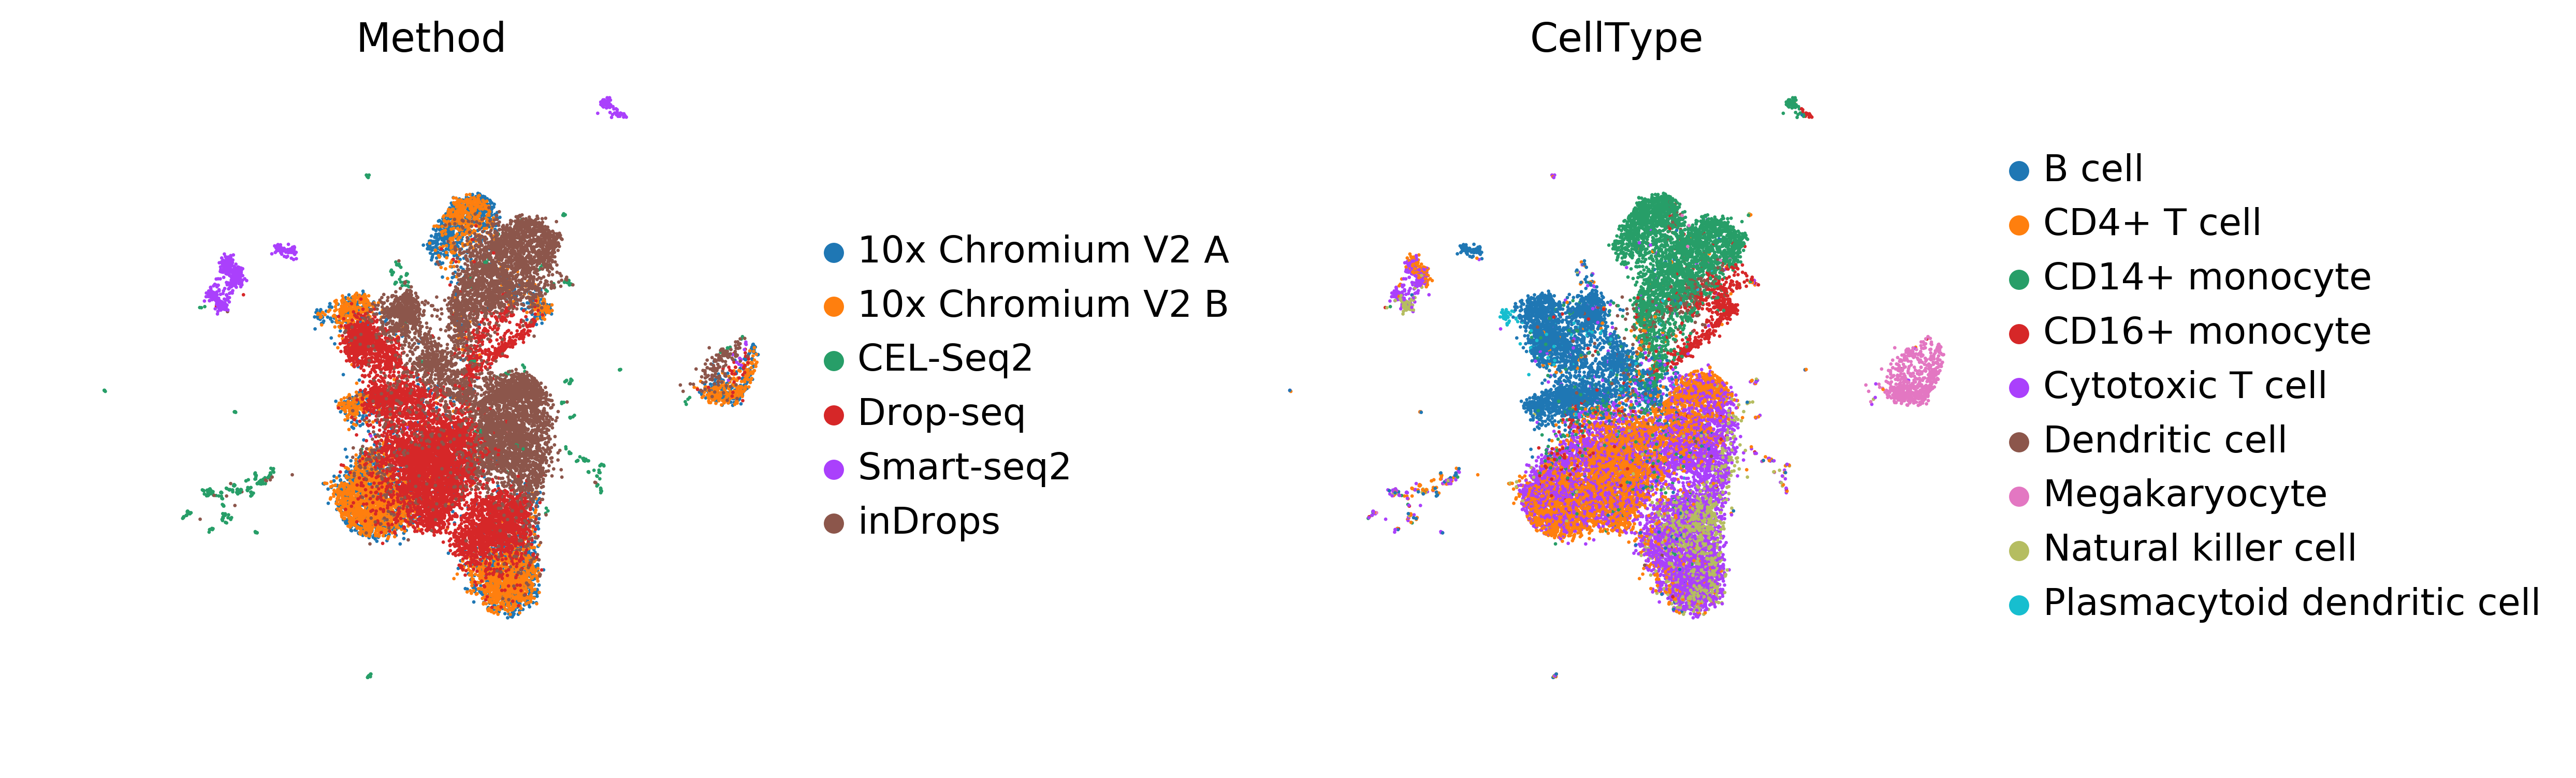

In [13]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=0.5)

## Now we leave out one study  (Drop-seq) for training the newtork

In [14]:
adata_for_training = adata[adata.obs[condition_key] != target_condition]
adata_for_training

View of AnnData object with n_obs × n_vars = 13971 × 1000 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts'
    var: 'ENS', 'Name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'Method_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_umap'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


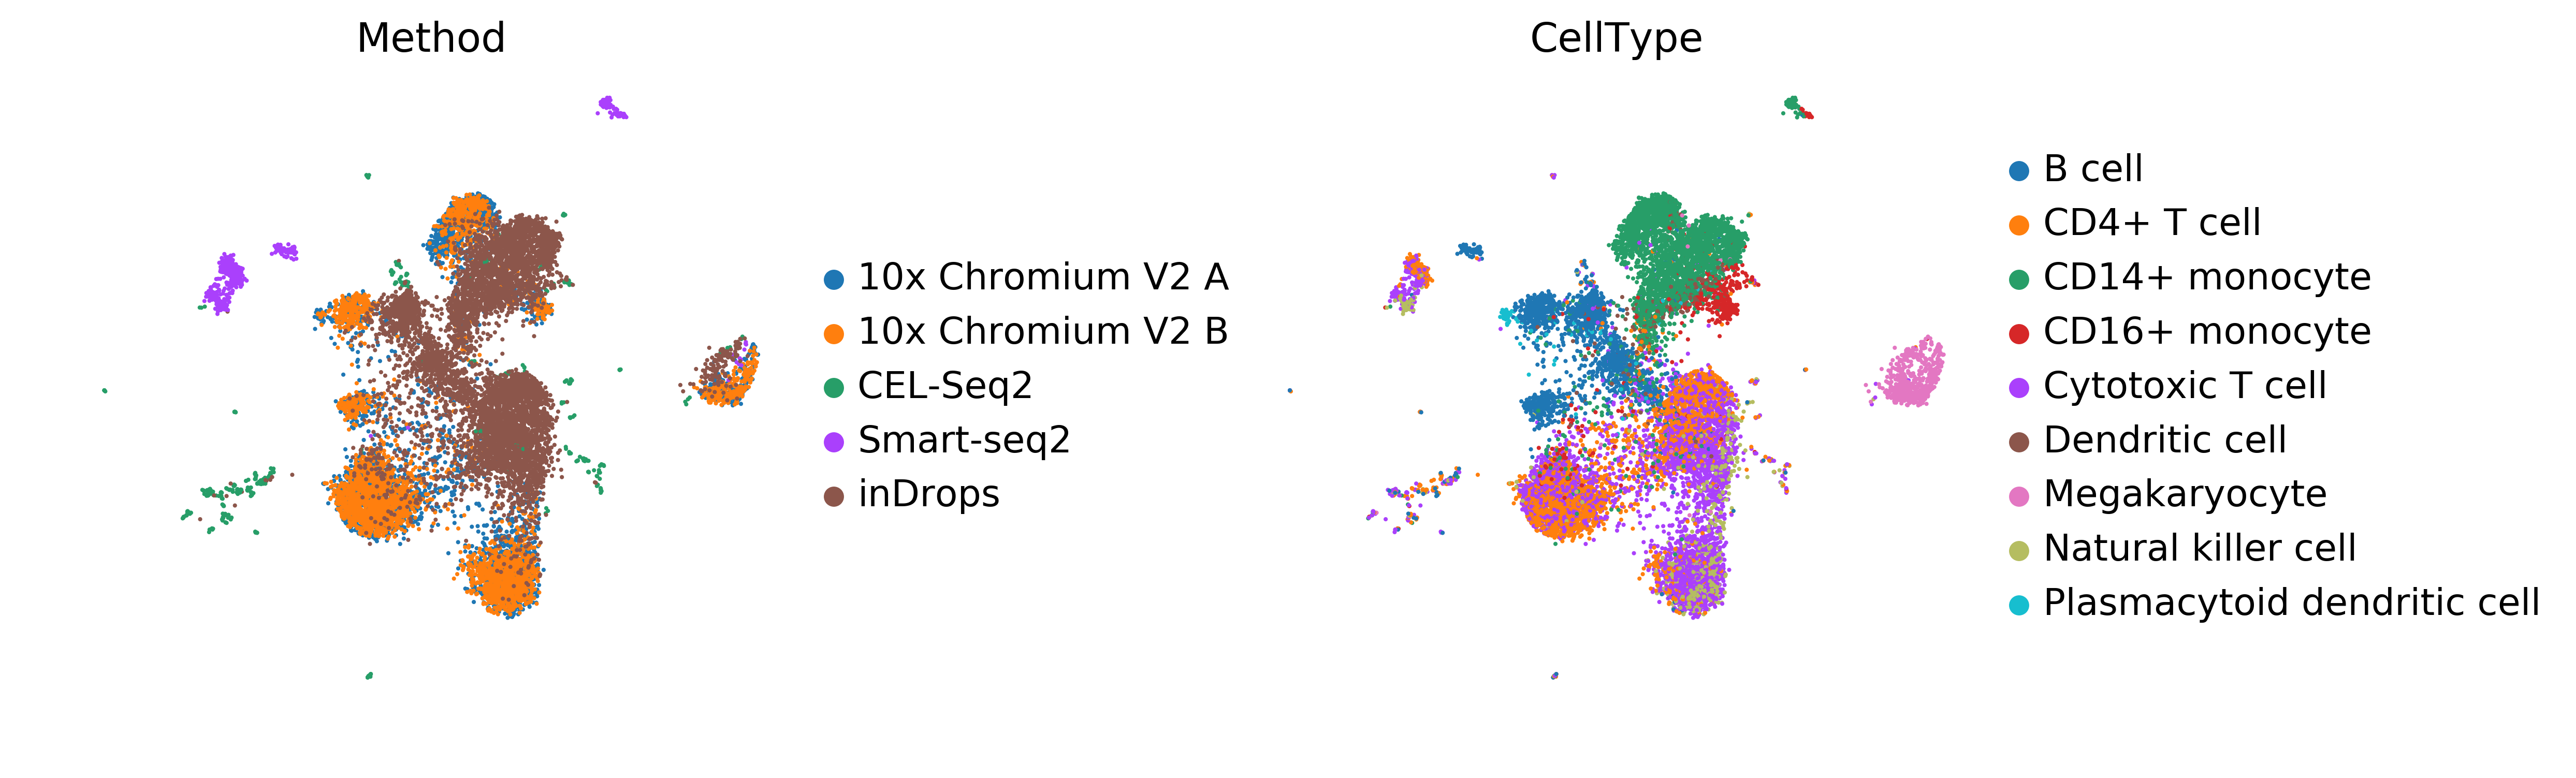

In [15]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [16]:
adata_out_of_sample = adata[adata.obs[condition_key] == target_condition]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 6584 × 1000 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts'
    var: 'ENS', 'Name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'Method_colors', 'CellType_colors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [17]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [18]:
train_adata.shape, valid_adata.shape

((11875, 1000), (2096, 1000))

In [19]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [20]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=100.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/PBMC/",
                             dropout_rate=0.2,
                             output_activation='relu')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          514560      concatenate_1[0][0]              
__________

## We assign each study to a numerical label 

In [21]:
adata.obs[condition_key].value_counts()

inDrops              6584
Drop-seq             6584
10x Chromium V2 B    3222
10x Chromium V2 A    3222
Smart-seq2            526
CEL-Seq2              417
Name: Method, dtype: int64

In [22]:
condition_encoder = {'inDrops': 0,
                     '10x Chromium V2 B': 1, '10x Chromium V2 A': 2, 'Smart-seq2': 3,
                     "CEL-Seq2": 4, }

## Training the network

In [23]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=300,
              batch_size=128, 
              early_stop_limit=25,
              lr_reducer=15, 
              save=True, 
              verbose=2)

Train on 11875 samples, validate on 2096 samples
Epoch 1/300
 - 9s - loss: 126.9380 - kl_recon_loss: 126.9380 - val_loss: 104.5973 - val_kl_recon_loss: 104.5973
Epoch 2/300
 - 0s - loss: 101.9695 - kl_recon_loss: 101.9695 - val_loss: 99.6374 - val_kl_recon_loss: 99.6374
Epoch 3/300
 - 1s - loss: 98.9945 - kl_recon_loss: 98.9945 - val_loss: 97.4422 - val_kl_recon_loss: 97.4422
Epoch 4/300
 - 0s - loss: 97.5408 - kl_recon_loss: 97.5408 - val_loss: 95.9178 - val_kl_recon_loss: 95.9178
Epoch 5/300
 - 1s - loss: 96.6840 - kl_recon_loss: 96.6840 - val_loss: 95.0503 - val_kl_recon_loss: 95.0503
Epoch 6/300
 - 1s - loss: 95.9583 - kl_recon_loss: 95.9583 - val_loss: 94.6886 - val_kl_recon_loss: 94.6886
Epoch 7/300
 - 1s - loss: 95.5607 - kl_recon_loss: 95.5607 - val_loss: 94.2587 - val_kl_recon_loss: 94.2587
Epoch 8/300
 - 1s - loss: 95.0749 - kl_recon_loss: 95.0749 - val_loss: 93.9401 - val_kl_recon_loss: 93.9401
Epoch 9/300
 - 1s - loss: 94.7060 - kl_recon_loss: 94.7060 - val_loss: 93.5819 - 

Epoch 76/300
 - 0s - loss: 88.3907 - kl_recon_loss: 88.3907 - val_loss: 90.4247 - val_kl_recon_loss: 90.4247
Epoch 77/300
 - 0s - loss: 88.3776 - kl_recon_loss: 88.3776 - val_loss: 90.3233 - val_kl_recon_loss: 90.3233
Epoch 78/300
 - 0s - loss: 88.3991 - kl_recon_loss: 88.3991 - val_loss: 90.4476 - val_kl_recon_loss: 90.4476
Epoch 79/300
 - 1s - loss: 88.4134 - kl_recon_loss: 88.4134 - val_loss: 90.2550 - val_kl_recon_loss: 90.2550
Epoch 80/300
 - 0s - loss: 88.3165 - kl_recon_loss: 88.3165 - val_loss: 90.2633 - val_kl_recon_loss: 90.2633
Epoch 81/300
 - 0s - loss: 88.3117 - kl_recon_loss: 88.3117 - val_loss: 90.2886 - val_kl_recon_loss: 90.2886
Epoch 82/300
 - 0s - loss: 88.2956 - kl_recon_loss: 88.2956 - val_loss: 90.3124 - val_kl_recon_loss: 90.3124
Epoch 83/300
 - 0s - loss: 88.3145 - kl_recon_loss: 88.3145 - val_loss: 90.3104 - val_kl_recon_loss: 90.3104
Epoch 84/300
 - 0s - loss: 88.1418 - kl_recon_loss: 88.1418 - val_loss: 90.2237 - val_kl_recon_loss: 90.2237
Epoch 85/300
 - 0s 

Epoch 151/300
 - 0s - loss: 86.7352 - kl_recon_loss: 86.7352 - val_loss: 89.8588 - val_kl_recon_loss: 89.8588
Epoch 152/300
 - 0s - loss: 86.8346 - kl_recon_loss: 86.8346 - val_loss: 89.8209 - val_kl_recon_loss: 89.8209
Epoch 153/300
 - 0s - loss: 86.7401 - kl_recon_loss: 86.7401 - val_loss: 89.7416 - val_kl_recon_loss: 89.7416
Epoch 154/300
 - 0s - loss: 86.7735 - kl_recon_loss: 86.7735 - val_loss: 89.7596 - val_kl_recon_loss: 89.7596
Epoch 155/300
 - 0s - loss: 86.7929 - kl_recon_loss: 86.7929 - val_loss: 89.8244 - val_kl_recon_loss: 89.8244
Epoch 156/300
 - 0s - loss: 86.6730 - kl_recon_loss: 86.6730 - val_loss: 89.8402 - val_kl_recon_loss: 89.8402
Epoch 157/300
 - 0s - loss: 86.7270 - kl_recon_loss: 86.7270 - val_loss: 89.8987 - val_kl_recon_loss: 89.8987
Epoch 158/300
 - 0s - loss: 86.6508 - kl_recon_loss: 86.6508 - val_loss: 89.8921 - val_kl_recon_loss: 89.8921
Epoch 159/300
 - 0s - loss: 86.6590 - kl_recon_loss: 86.6590 - val_loss: 89.7569 - val_kl_recon_loss: 89.7569
Epoch 160/

In [24]:
network.condition_encoder

{'inDrops': 0,
 '10x Chromium V2 B': 1,
 '10x Chromium V2 A': 2,
 'Smart-seq2': 3,
 'CEL-Seq2': 4}

In [25]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [26]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 11875 × 10 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts'

In [27]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

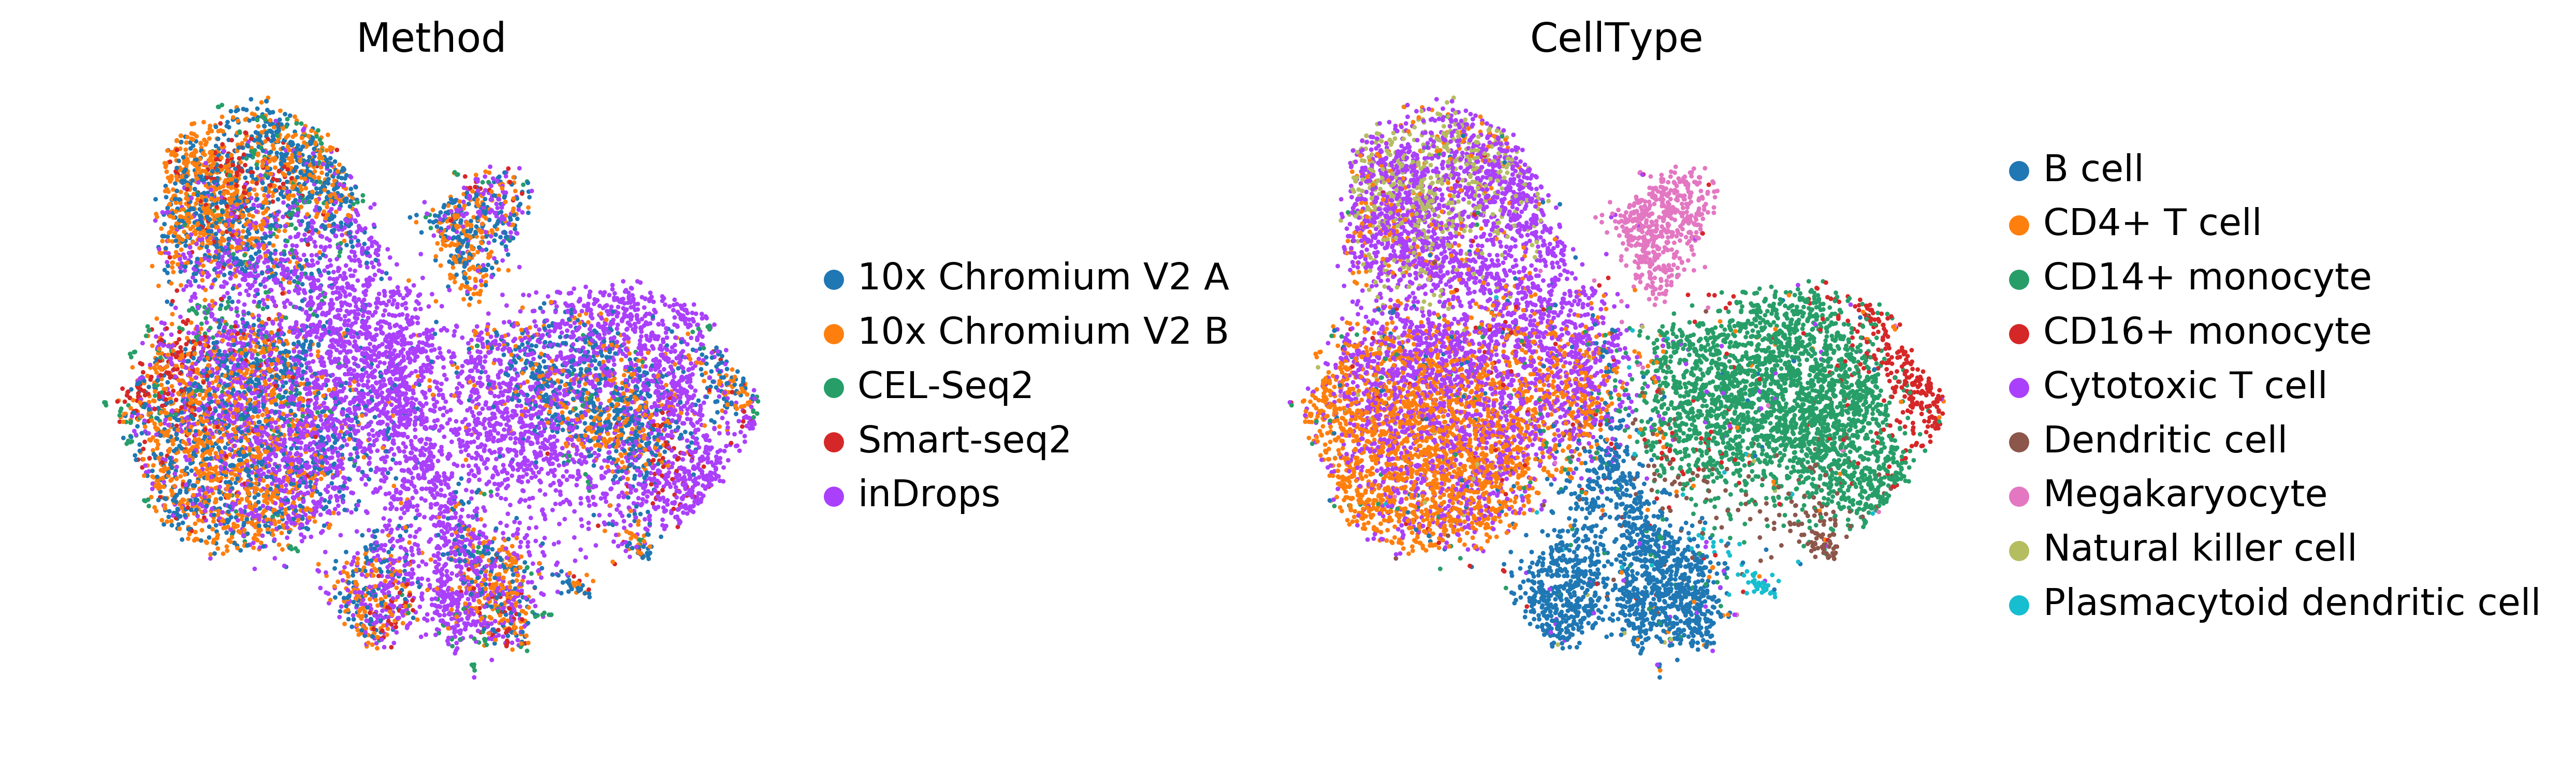

In [28]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Perfroming architecture Surgery

In [29]:
new_network = surgeon.operate(network, 
                              new_condition=target_condition,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 6)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1006)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          515072      concatenate_3[0][0]              
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 6)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1006)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          515072      concatenate_3[0][0]              
__________

In [30]:
new_network.condition_encoder

{'inDrops': 0,
 '10x Chromium V2 B': 1,
 '10x Chromium V2 A': 2,
 'Smart-seq2': 3,
 'CEL-Seq2': 4,
 'Drop-seq': 5}

## Train with small new dataset containing out-of-sample condition

In [31]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.85)

In [32]:
train_adata.shape, valid_adata.shape

((5596, 1000), (988, 1000))

In [33]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=100,
                  batch_size=128, 
                  early_stop_limit=25,
                  lr_reducer=20, 
                  save=True, 
                  verbose=2)

Train on 5596 samples, validate on 988 samples
Epoch 1/100
 - 1s - loss: 87.6634 - kl_recon_loss: 87.6634 - val_loss: 84.1159 - val_kl_recon_loss: 84.1159
Epoch 2/100
 - 0s - loss: 85.1556 - kl_recon_loss: 85.1556 - val_loss: 83.1883 - val_kl_recon_loss: 83.1883
Epoch 3/100
 - 0s - loss: 84.2235 - kl_recon_loss: 84.2235 - val_loss: 82.8756 - val_kl_recon_loss: 82.8756
Epoch 4/100
 - 0s - loss: 83.5483 - kl_recon_loss: 83.5483 - val_loss: 82.5145 - val_kl_recon_loss: 82.5145
Epoch 5/100
 - 0s - loss: 83.1635 - kl_recon_loss: 83.1635 - val_loss: 82.3841 - val_kl_recon_loss: 82.3841
Epoch 6/100
 - 0s - loss: 82.6951 - kl_recon_loss: 82.6951 - val_loss: 82.2676 - val_kl_recon_loss: 82.2676
Epoch 7/100
 - 0s - loss: 82.5442 - kl_recon_loss: 82.5442 - val_loss: 82.0012 - val_kl_recon_loss: 82.0012
Epoch 8/100
 - 0s - loss: 82.2972 - kl_recon_loss: 82.2972 - val_loss: 81.5900 - val_kl_recon_loss: 81.5900
Epoch 9/100
 - 0s - loss: 82.0410 - kl_recon_loss: 82.0410 - val_loss: 81.4860 - val_kl_r

Epoch 76/100
 - 0s - loss: 79.9718 - kl_recon_loss: 79.9718 - val_loss: 80.1563 - val_kl_recon_loss: 80.1563
Epoch 77/100
 - 0s - loss: 80.0338 - kl_recon_loss: 80.0338 - val_loss: 80.0648 - val_kl_recon_loss: 80.0648
Epoch 78/100
 - 0s - loss: 80.0635 - kl_recon_loss: 80.0635 - val_loss: 80.0533 - val_kl_recon_loss: 80.0533
Epoch 79/100
 - 0s - loss: 80.0674 - kl_recon_loss: 80.0674 - val_loss: 79.9693 - val_kl_recon_loss: 79.9693
Epoch 80/100
 - 0s - loss: 80.0480 - kl_recon_loss: 80.0480 - val_loss: 80.0793 - val_kl_recon_loss: 80.0793
Epoch 81/100
 - 0s - loss: 79.9757 - kl_recon_loss: 79.9757 - val_loss: 79.9676 - val_kl_recon_loss: 79.9676
Epoch 82/100
 - 0s - loss: 79.9191 - kl_recon_loss: 79.9191 - val_loss: 79.9208 - val_kl_recon_loss: 79.9208
Epoch 83/100
 - 0s - loss: 79.9273 - kl_recon_loss: 79.9273 - val_loss: 80.0996 - val_kl_recon_loss: 80.0996
Epoch 84/100
 - 0s - loss: 79.9169 - kl_recon_loss: 79.9169 - val_loss: 80.0472 - val_kl_recon_loss: 80.0472
Epoch 85/100
 - 0s 

In [34]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [35]:
adata.obs[condition_key].value_counts()

inDrops              6584
Drop-seq             6584
10x Chromium V2 B    3222
10x Chromium V2 A    3222
Smart-seq2            526
CEL-Seq2              417
Name: Method, dtype: int64

In [36]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 20555 × 10 
    obs: 'Experiment', 'Method', 'CBC', 'CellType', 'n_counts'

In [37]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

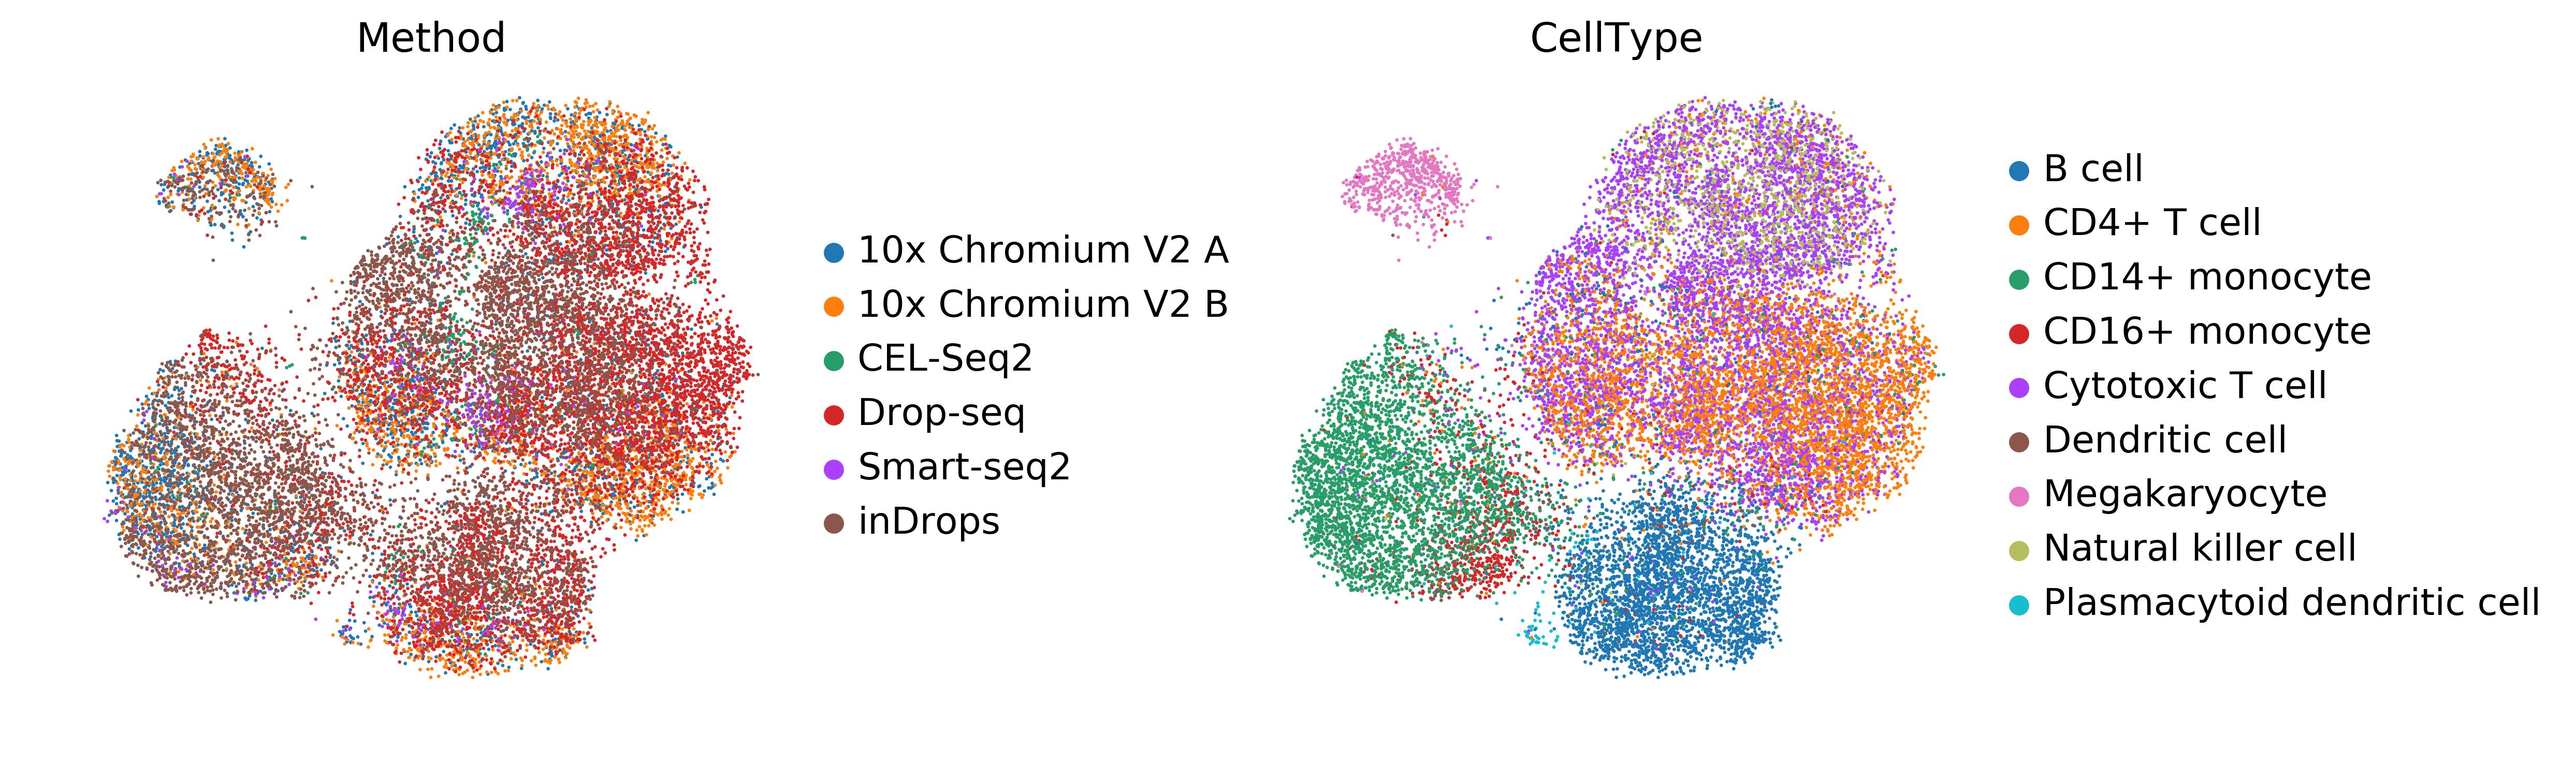

In [38]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

# Now Let's add  another  PBMC data set from 10x

In [43]:
adata_PBMC = sc.read("data/PBMC/pbmc3k.h5ad")

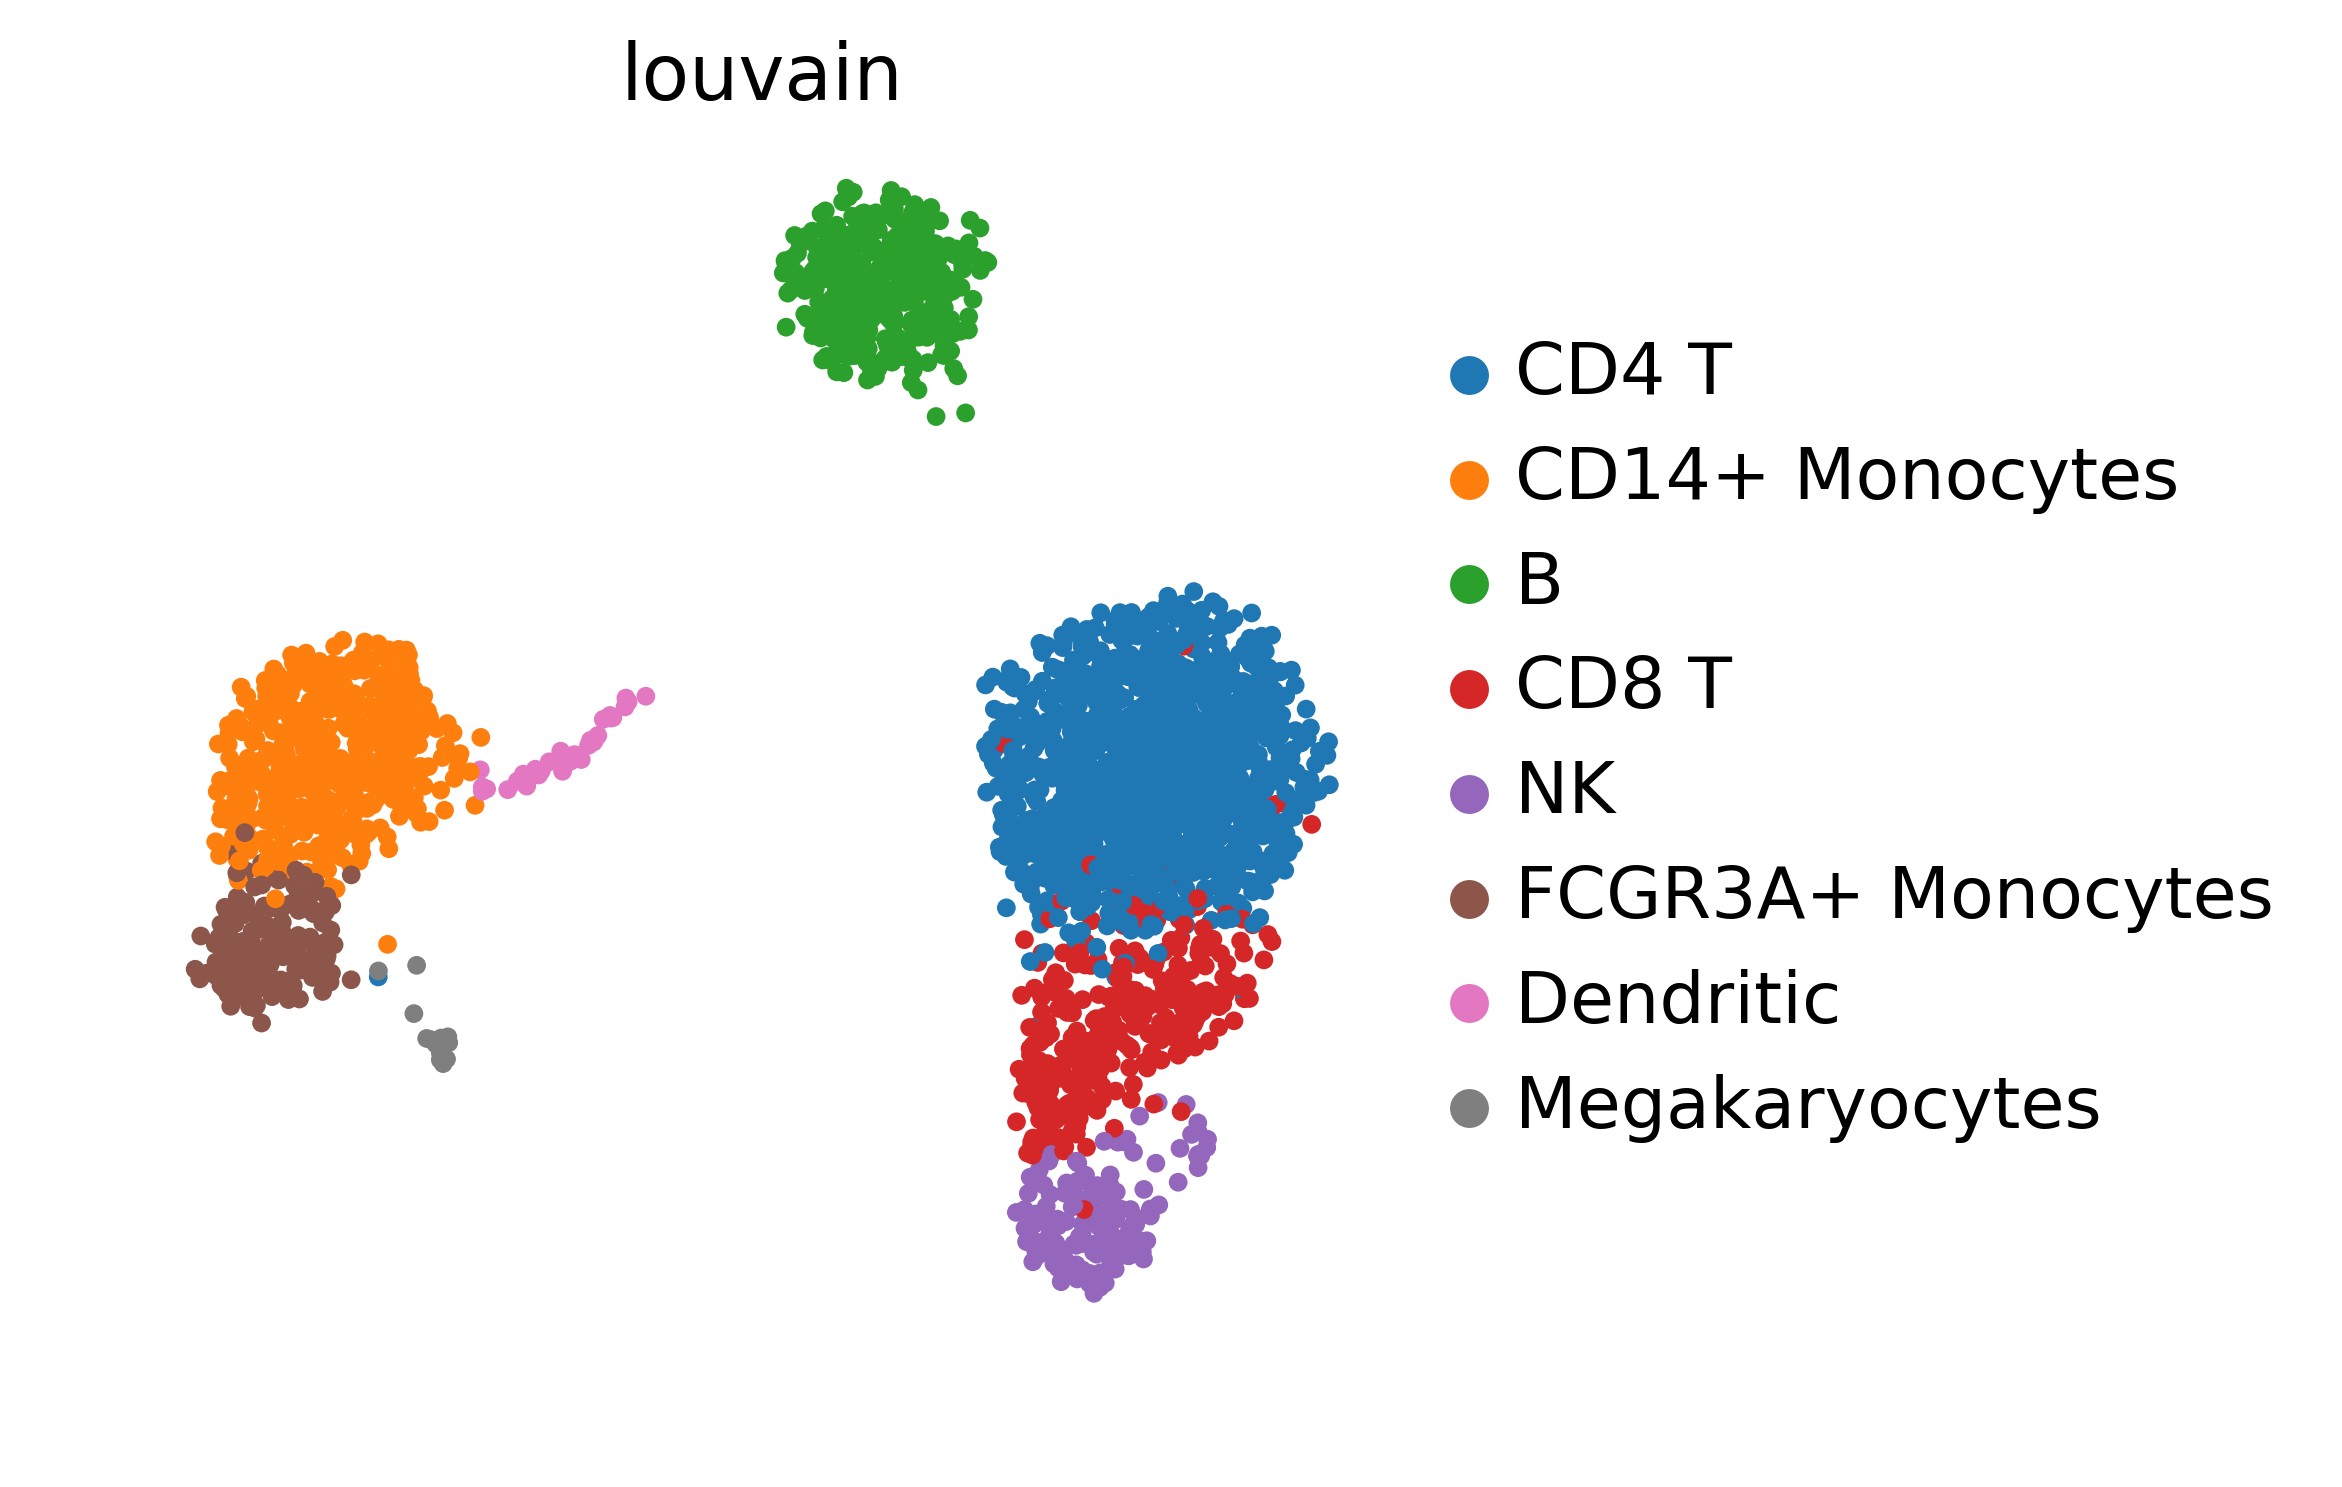

In [60]:
sc.pl.umap(adata_PBMC, color="louvain")

## Selecting same genes from original data 

In [72]:
sc.datasets.pbmc68k_reduced()

<module 'scanpy.datasets' from '/home/mohammad/packages/scanpy/scanpy/datasets/__init__.py'>

In [62]:
adata.var_names

(1000,)

In [75]:
a = adata_PBMC.raw

In [79]:
a.obs

AttributeError: 'Raw' object has no attribute 'obs'

In [63]:
adata_subset = adata_PBMC[:, adata.var_names.tolist()]

/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/pandas/core/series.py:951: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


KeyError: "Values ['ANKIB1', 'LASP1', 'ST7', 'RALA', 'TSR3', 'TENM1', 'PHF7', 'TSPAN9', 'EHD3', 'MAN2B2', 'MAMLD1', 'ZMYND11', 'CD74', 'SPAST', 'AGPAT4', 'POU2F2', 'IKZF2', 'IFT88', 'GAB2', 'MAP2K3', 'VCL', 'PHLPP2', 'RETSAT', 'DCUN1D1', 'CNTLN', 'ADAMTS6', 'LTBP1', 'LY75', 'PTPRN', 'HDAC7', 'NCKAP1', 'GUCY1B3', 'U2AF2', 'CTSA', 'MYLK', 'ASB1', 'ZMYND12', 'GOLGA5', 'TFE3', 'REEP1', 'ATP11A', 'MAST4', 'BCL3', 'MAOB', 'TGFBR3', 'PABPC1', 'ATP6AP1', 'ACTN1', 'PTPN18', 'MPP5', 'RHOBTB1', 'SIDT1', 'ALPK1', 'GSDMB', 'TBX21', 'FRY', 'FNDC3B', 'ACTB', 'MCM6', 'RBMS2', 'UNG', 'POLD3', 'MAP2', 'TNRC6C', 'FKBP7', 'KEAP1', 'SMARCA2', 'CDC14B', 'ITGB5', 'PALB2', 'SSH1', 'AGBL5', 'IPO11', 'EPDR1', 'SEPHS1', 'FTL', 'CETP', 'TXNDC16', 'GP6', 'SMOX', 'C20orf194', 'RP5-1187M17.10', 'LYZ', 'CMTM6', 'SLC22A17', 'RFFL', 'DPYSL2', 'SUCO', 'ABL1', 'HIRA', 'HMOX1', 'MYH9', 'GRAP2', 'CSF2RB', 'ABHD4', 'CDKL1', 'TMED8', 'DAAM1', 'PPM1A', 'ZFYVE21', 'PAPLN', 'PABPN1', 'SIRPB1', 'PLCB4', 'HCK', 'E2F1', 'RPRD1B', 'TNNC2', 'ADNP2', 'POLA1', 'TLR8', 'GATA1', 'PHEX', 'UBL4A', 'PCYT1B', 'CAB39L', 'FGF9', 'KATNAL1', 'CRISPLD2', 'SLC7A5', 'EEF2K', 'UBFD1', 'CPPED1', 'XYLT1', 'ACSBG1', 'MYEF2', 'IMPAD1', 'SPAG1', 'AKT2', 'SLC1A5', 'PTPRS', 'CABP5', 'JAK3', 'SCN1B', 'CADM4', 'PIK3CG', 'SP4', 'MTPN', 'LMBR1', 'CPED1', 'FAM188B', 'USP42', 'GLCCI1', 'TMEM245', 'C5', 'DNM1', 'RLN1', 'TESK1', 'ZFAND5', 'PDLIM1', 'EDRF1', 'DHX40', 'TUBD1', 'SMARCD2', 'CCL8', 'DLX4', 'TNFAIP1', 'TMEM97', 'SLAIN2', 'USP46', 'VWA5A', 'CPT1A', 'PANX1', 'EIF4G2', 'MDK', 'HPS5', 'DUSP16', 'CREBL2', 'VDR', 'TBC1D30', 'CMAS', 'UST', 'MAPK14', 'KCTD20', 'SRF', 'DUSP22', 'LY86', 'CEP72', 'HMGCR', 'SLC12A7', 'ERGIC1', 'CPEB4', 'BCL6', 'RBP1', 'FRMD4B', 'SCAP', 'INO80D', 'IL1R1', 'QPCT', 'SLC1A4', 'ARID3A', 'EPHA4', 'MARK1', 'CHD5', 'SCAMP3', 'LEPR', 'GADD45A', 'RGS2', 'KIF21B', 'NID1', 'TNFSF4', 'PRDX6', 'ESYT2', 'KLF7', 'B4GALT6', 'TNFAIP3', 'UBN1', 'CCDC92', 'FBXW2', 'NEK9', 'MLH3', 'FKBP1B', 'OGFRL1', 'MXI1', 'MOB3B', 'CENPL', 'MASTL', 'PLXDC2', 'DUSP4', 'PAPD5', 'DPPA4', 'ZCCHC17', 'SLC25A51', 'CALD1', 'RNF11', 'SDC4', 'ATP8A1', 'MED20', 'OR2B6', 'MEA1', 'CDKN1A', 'EMC3', 'MT1G', 'TMTC4', 'MED1', 'RPL23', 'RTN2', 'MAX', 'DYNLRB1', 'IGFLR1', 'RHOT1', 'BCL11B', 'HRASLS', 'KLF2', 'SYNGR3', 'TUBA4A', 'VIL1', 'RNF6', 'ASPHD2', 'YWHAH', 'GNAZ', 'DCTD', 'KIF1C', 'RAB2B', 'MAU2', 'XPO7', 'C6orf203', 'OLFM1', 'PAK4', 'ZNF317', 'LATS1', 'ZNF428', 'GSE1', 'CHSY1', 'JCHAIN', 'NIP7', 'SYT11', 'DPH2', 'MYH10', 'LGALS12', 'HRASLS2', 'AGAP3', 'MICAL2', 'VAV3', 'SORT1', 'NAPG', 'GRHL1', 'CMPK2', 'SPX', 'ERCC5', 'GOLM1', 'ADAM19', 'SDS', 'HILPDA', 'SRPK2', 'ORC3', 'KIAA0513', 'TTLL4', 'TMEM127', 'LRCH1', 'TTYH3', 'CIB2', 'BRIP1', 'HLX', 'NIPSNAP3A', 'PIM1', 'FRS3', 'FCHSD2', 'RAB30', 'GGH', 'SORL1', 'TRPC6', 'TMPRSS13', 'HAUS2', 'UACA', 'DYNC2LI1', 'PREPL', 'COX17', 'MMRN1', 'PDE5A', 'SCARB2', 'ANXA3', 'METTL20', 'POC1B', 'SLC7A1', 'CCDC65', 'NABP2', 'CSAD', 'PELI2', 'RTN1', 'SLC12A6', 'TLE3', 'CRTC3', 'FTO', 'DEF8', 'TOM1L1', 'SS18', 'RPRD1A', 'NPC1', 'CTB-55O6.8', 'APP', 'ZNF697', 'STRIP1', 'ECM1', 'PIP5K1A', 'GABPB2', 'AQP10', 'SDE2', 'LEFTY2', 'MEIS1', 'COPS7B', 'SLC25A38', 'CTDSPL', 'ENOPH1', 'CISD2', 'FBXL17', 'FEM1C', 'PPP1R18', 'CREB5', 'ZC3HAV1L', 'LANCL3', 'NXF3', 'MFHAS1', 'ZNF185', 'NFIB', 'LCN2', 'PROSER2', 'USP6NL', 'RSU1', 'PARD3', 'RGS10', 'TUT1', 'MPZL2', 'CABLES2', 'TIRAP', 'DHX37', 'DLG5', 'EIF4E', 'MBIP', 'PTPRO', 'FAM160B1', 'TEX9', 'ZNF385D', 'RABGAP1L', 'EPG5', 'SPOCK1', 'RAD17', 'PLOD2', 'DAB2', 'AHCTF1', 'RBMS1', 'LPCAT1', 'ANGPT1', 'CEP112', 'ABCA6', 'TRIM11', 'TMSB4Y', 'VOPP1', 'APOOL', 'MARVELD1', 'HSPA13', 'DBI', 'CFAP161', 'ZNF689', 'B3GNT7', 'EXOG', 'LRP8', 'DHRS1', 'TMEM164', 'MX1', 'TAB3', 'MRAS', 'HIST1H2BD', 'CNOT11', 'TAGLN2', 'SLC45A3', 'PINK1', 'RAPGEF6', 'ADIPOR1', 'HK2', 'FAM131B', 'CALM3', 'ZNF362', 'VAV2', 'MED27', 'MAML1', 'DVL3', 'ASRGL1', 'NXF1', 'TPCN2', 'CMPK1', 'PLPP3', 'NEXN', 'TRIM58', 'MEMO1', 'RPRD2', 'S100A9', 'PAQR3', 'HIPK1', 'SGOL2', 'PRKCI', 'RYBP', 'ATXN7', 'RPN1', 'UVSSA', 'MON1A', 'NAA15', 'ELOVL7', 'LMBRD2', 'GDF9', 'STXBP5', 'SAP30L', 'SLC29A4', 'ALDH7A1', 'SLC25A32', 'DCSTAMP', 'TMEM65', 'ABCA1', 'CYBB', 'ZNF367', 'ARMC3', 'CRYL1', 'FAM175B', 'ZMYND19', 'NDRG2', 'SALL2', 'ZFYVE1', 'TTC7B', 'ARL5B', 'LIPC', 'LRTM2', 'DPCD', 'IDH3A', 'CLEC4D', 'SLC38A8', 'NGFRAP1', 'CATSPER2', 'RBPMS2', 'PATL1', 'MAP1A', 'MAPRE2', 'SGSM1', 'PBX3', 'ZNF668', 'SPATA33', 'FTH1', 'C11orf84', 'TRANK1', 'SAC3D1', 'IRF2BP2', 'IRF2', 'RAB31', 'LDLRAD4', 'SEMA4C', 'E2F6', 'IRS1', 'HSPBAP1', 'GPRIN1', 'RNASE2', 'CXCL8', 'LIMS1', 'P2RY1', 'TPST1', 'TM4SF1', 'CNTROB', 'PWWP2A', 'DCLK2', 'PFKFB3', 'ARL6IP1', 'MTM1', 'BCL2L1', 'CLSTN1', 'SERF1A', 'FRMD3', 'MACROD2', 'BPGM', 'SLFN11', 'TMCC1', 'MYEOV', 'PHF8', 'ADRBK1', 'BNC2', 'ABLIM3', 'MINOS1', 'CEP83', 'HEG1', 'DPY19L1', 'TCAP', 'SELP', 'RALGAPA1', 'UGT8', 'SLC29A2', 'BRSK2', 'FGFBP3', 'DNAH12', 'ZDHHC14', 'CABP4', 'C15orf54', 'DLEU1', 'UFSP1', 'SLC35G1', 'LPCAT4', 'SLCO3A1', 'DIRAS1', 'RUFY1', 'BASP1', 'FAM210A', 'ULK1', 'BEND2', 'RP11-218M22.1', 'TGIF1', 'RBM44', 'IRX3', 'CD151', 'FAM20C', 'ZNF354C', 'CENPBD1', 'NDUFAF3', 'DALRD3', 'RNF212', 'GALNT11', 'ZNF223', 'ERN1', 'APOLD1', 'TMEM107', 'CDC42EP4', 'C3orf80', 'LYNX1', 'MTURN', 'NRIP1', 'HIST1H2BC', 'NQO1', 'RP11-429J17.2', 'ZNF746', 'RAP2B', 'RP11-69E11.4', 'MRPS16', 'B4GALNT4', 'C8orf33', 'LIPF', 'PLCXD1', 'C2orf82', 'SKA2', 'NTM', 'CADM1', 'ABAT', 'BCOR', 'PRR14L', 'TANGO2', 'ZNF438', 'ALYREF', 'FAM101B', 'LHFP', 'PTP4A2', 'FAM132A', 'CSF1', 'PROS1', 'PDE4B', 'SNN', 'HIST2H2BE', 'F8', 'SLC24A3', 'MRPL30', 'C19orf68', 'SP1', 'LMLN', 'KCNQ5', 'LAMP1', 'KLHDC8B', 'IRS2', 'PIP5K1C', 'CD300E', 'C17orf58', 'PPARA', 'RHD', 'MITF', 'SLIT1', 'PEAR1', 'ARHGAP11B', 'RILPL1', 'CENPP', 'CHM', 'FAM83G', 'MTF1', 'FAT4', 'ZBTB44', 'ZNF34', 'PPP1R26', 'TSC22D2', 'AFAP1', 'CACNA1H', 'MMP1', 'TECPR2', 'ZNF418', 'ZFP28', 'LRRC8B', 'SHPK', 'PDGFA', 'TOPORS', 'BCO2', 'SERPINB2', 'DNM3', 'LPAR1', 'TMEM229B', 'CARD11', 'SPRED2', 'MAFK', 'C3orf35', 'COPS8', 'NCOA6', 'PAPSS2', 'GLMP', 'GK', 'MT-ND3', 'PNMA5', 'MT-ND4', 'MT-ND1', 'L1CAM', 'SREBF2', 'GPRASP1', 'AC015969.3', 'INF2', 'C1orf132', 'RPA4', 'TRAF3IP1', 'STK19', 'HSPA1A', 'PRR3', 'PPP1R11', 'FAM83A-AS1', 'TRIQK', 'TMEM170B', 'MFSD2B', 'ITSN1', 'RP11-689P11.2', 'IGKC', 'IGLV3-25', 'IGLV2-14', 'IGLC2', 'IGLC3', 'IGHA2', 'IGHG2', 'IGHA1', 'IGHG3', 'IGHV2-5', 'RNF208', 'RP1-206D15.6', 'FGFR1OP', 'NRAS', 'KRTAP4-12', 'ZNF788', 'SH3D21', 'C17orf67', 'ANG', 'ISPD', 'ZGLP1', 'AC092198.1', 'HRAT92', 'AC002456.2', 'AC005076.5', 'ADM5', 'LINC00853', 'POT1-AS1', 'LINC00337', 'AC013733.4', 'RP11-70C1.1', 'AC087501.1', 'RP1-309F20.3', 'AC105393.2', 'WDR11-AS1', 'ST7-AS1', 'FAM212B-AS1', 'RP3-395M20.9', 'AC093495.4', 'RP11-556E13.1', 'BACH1-IT2', 'AC104653.1', 'AC091729.9', 'AC020571.3', 'RPL41', 'RP11-172E9.2', 'AC021188.4', 'RP11-175O19.4', 'RP11-88H9.2', 'LINC00441', 'FSIP2-AS1', 'RP11-177F15.1', 'RP11-307C12.11', 'LINC00865', 'AC078883.3', 'RP11-375A5.1', 'LINC00264', 'STXBP5-AS1', 'B4GALT1-AS1', 'RP11-354E11.2', 'ZFX-AS1', 'ZNF879', 'JAZF1-AS1', 'AC004231.2', 'RP11-122K13.12', 'AF127936.9', 'AC116614.1', 'TMEM147-AS1', 'CLEC2L', 'RP3-329E20.2', 'RP11-298E9.5', 'RP11-324C10.1', 'RP11-185E8.1', 'AQP1', 'CD302', 'C8orf58', 'NPPA-AS1', 'KCTD7', 'IL10RB', 'IFITM10', 'RP11-1398P2.1', 'NEAT1', 'RP11-539L10.2', 'USP51', 'RP11-32B5.7', 'RP11-556I14.2', 'MEF2C-AS1', 'RP11-768F21.1', 'LINC01088', 'RP11-677M14.3', 'RP11-381K20.2', 'LINC00989', 'RP11-466P24.6', 'RP11-734I18.1', 'RP11-48B3.5', 'LINC01151', 'AP003068.23', 'RP11-395G23.3', 'RP11-672A2.4', 'CTD-2509G16.2', 'CTD-3065J16.9', 'RP11-96B2.1', 'RP11-513D5.5', 'SMIM3', 'PWAR6', 'RP11-977G19.11', 'FNTB', 'RP11-84G21.1', 'RP11-620J15.3', 'RP11-1143G9.4', 'RP11-8L8.2', 'RP11-293M10.6', 'INAFM2', 'RP11-930O11.1', 'AL022344.7', 'RBM15B', 'LINC00657', 'RP11-568N6.1', 'RP5-1085F17.3', 'RP11-111J6.2', 'LINC00562', 'RP13-516M14.1', 'AP000223.42', 'RP11-152L20.3', 'RP11-439E19.9', 'RP11-211G23.2', 'RP11-819C21.1', 'RP3-388M5.9', 'AC137932.6', 'RP13-638C3.4', 'AC144831.1', 'LA16c-325D7.2', 'RP11-401O9.3', 'DYNLL2', 'RP1-56K13.3', 'BAHCC1', 'RP11-1C8.6', 'RP11-874J12.4', 'RP5-1148A21.3', 'FXYD1', 'RP13-890H12.2', 'ZNF582-AS1', 'IKBKG', 'RP11-646I6.5', 'CASC15', 'CTC-428H11.2', 'XXbac-BPG252P9.9', 'AFAP1-AS1', 'RP11-422P24.11', 'RP11-191L17.1', 'RP5-943J3.2', 'RP11-351D16.3', 'CTB-13F3.1', 'XXyac-YX155B6.7', 'RP11-165A20.3', 'AP000254.8', 'RP11-448A19.1', 'RP11-686O6.2', 'C17orf96', 'USP27X', 'CTD-2017F17.2', 'RP13-820C6.4', 'RP11-214K3.24', 'HIST1H2BH', 'CCL3L3', 'PIP4K2B', 'DACH1', 'AC007950.2', 'HIST1H2AE', 'HIST1H2BF', 'ZNF670', 'RP11-278A23.4', 'RP11-706P11.2', 'HIST1H3H', 'RP11-414C23.1', 'FO538757.3', 'GVQW2', 'CH507-513H4.3', 'SEPSECS-AS1', 'LLNLR-245B6.1'], from ['ANKIB1', 'LASP1', 'ST7', 'PRKAR2B', 'ITGA2B', 'RALA', 'TBXA2R', 'TSR3', 'TENM1', 'CD9', 'PHF7', 'TSPAN9', 'EHD3', 'MAN2B2', 'MAMLD1', 'ZMYND11', 'CD74', 'SPAST', 'FHL1', 'AGPAT4', 'POU2F2', 'IKZF2', 'IFT88', 'GAB2', 'MAP2K3', 'VCL', 'PHLPP2', 'RETSAT', 'DCUN1D1', 'CNTLN', 'FAM120A', 'ADAMTS6', 'LTBP1', 'LY75', 'PTPRN', 'ATP9A', 'HDAC7', 'NCKAP1', 'GUCY1B3', 'U2AF2', 'CTSA', 'MYLK', 'ASB1', 'ZMYND12', 'GOLGA5', 'TFE3', 'REEP1', 'ATP11A', 'MAST4', 'BCL3', 'MAOB', 'TGFBR3', 'AP3M2', 'PABPC1', 'ATP6AP1', 'ACTN1', 'PTPN18', 'MPP5', 'RHOBTB1', 'SIDT1', 'ALPK1', 'GSDMB', 'TBX21', 'FRY', 'FNDC3B', 'FOSL2', 'ACTB', 'MCM6', 'RBMS2', 'UNG', 'TOP2B', 'POLD3', 'MAP2', 'ITM2A', 'TNRC6C', 'FKBP7', 'KEAP1', 'RAB21', 'SMARCA2', 'ARG2', 'CDC14B', 'ITGB5', 'PALB2', 'SSH1', 'AGBL5', 'CTTN', 'IPO11', 'EPDR1', 'SEPHS1', 'FTL', 'CETP', 'TXNDC16', 'GP6', 'TMEM40', 'SMOX', 'C20orf194', 'RP5-1187M17.10', 'DYNLL1', 'LYZ', 'CMTM6', 'SLC22A17', 'RFFL', 'DPYSL2', 'SUCO', 'PTGS1', 'ABL1', 'MARCH2', 'HIRA', 'TPTEP1', 'PACSIN2', 'HMOX1', 'MYH9', 'GRAP2', 'CSF2RB', 'ABHD4', 'CDKL1', 'TMED8', 'DAAM1', 'PPM1A', 'ZFYVE21', 'PAPLN', 'PABPN1', 'TUBB1', 'SIRPB1', 'PLCB4', 'MYL9', 'HCK', 'E2F1', 'RPRD1B', 'TNNC2', 'ADNP2', 'PGRMC1', 'POLA1', 'PRPS2', 'TLR8', 'GATA1', 'PHEX', 'UBL4A', 'PCYT1B', 'CAB39L', 'FGF9', 'KATNAL1', 'TSC22D1', 'CRISPLD2', 'SLC7A5', 'EEF2K', 'UBFD1', 'CPPED1', 'XYLT1', 'ACSBG1', 'MYEF2', 'CA2', 'IMPAD1', 'SPAG1', 'RELB', 'AURKC', 'AKT2', 'SLC1A5', 'PTPRS', 'CABP5', 'JAK3', 'SCN1B', 'CADM4', 'PIK3CG', 'SP4', 'MTPN', 'LMBR1', 'CPED1', 'FAM188B', 'USP42', 'GLCCI1', 'SPIN1', 'TMEM245', 'C5', 'DNM1', 'RLN1', 'TESK1', 'PTGDS', 'ZFAND5', 'PDLIM1', 'EDRF1', 'DHX40', 'TUBD1', 'SMARCD2', 'CCL8', 'DLX4', 'ALOX12', 'ABCC3', 'MMD', 'TNFAIP1', 'TMEM97', 'SLAIN2', 'USP46', 'MANBA', 'MTCH2', 'VWA5A', 'CPT1A', 'PANX1', 'EIF4G2', 'MDK', 'HPS5', 'DUSP16', 'CREBL2', 'VDR', 'TBC1D30', 'ACRBP', 'USP5', 'CMAS', 'UST', 'MAPK14', 'KCTD20', 'SRF', 'DUSP22', 'LY86', 'CEP72', 'SPARC', 'HMGCR', 'SLC12A7', 'PPP2CA', 'ERGIC1', 'CPEB4', 'BCL6', 'HGD', 'UBE3A', 'RBP1', 'FRMD4B', 'SCAP', 'INO80D', 'GNLY', 'IL1R1', 'QPCT', 'SLC1A4', 'ARID3A', 'EPHA4', 'MARK1', 'CHD5', 'SCAMP3', 'LEPR', 'GADD45A', 'RGS2', 'KIF21B', 'NID1', 'CD160', 'TNFSF4', 'PRDX6', 'ESYT2', 'KLF7', 'B4GALT6', 'TNFAIP3', 'UBN1', 'CCDC92', 'C1orf198', 'FBXW2', 'NEK9', 'MLH3', 'FKBP1B', 'OGFRL1', 'MXI1', 'MOB3B', 'CENPL', 'MASTL', 'PLXDC2', 'DUSP4', 'CLU', 'PAPD5', 'DPPA4', 'ZCCHC17', 'SERAC1', 'SLC25A51', 'CALD1', 'HVCN1', 'RNF11', 'PLA2G12A', 'SDC4', 'PMEPA1', 'ATP8A1', 'F13A1', 'HIST1H2BJ', 'MED20', 'OR2B6', 'MEA1', 'CDKN1A', 'EMC3', 'MT1G', 'TMTC4', 'MED1', 'RPL23', 'RTN2', 'MAX', 'DYNLRB1', 'IGFLR1', 'RHOT1', 'BCL11B', 'HRASLS', 'KLF2', 'SYNGR3', 'TUBA4A', 'VIL1', 'RNF6', 'GNG11', 'ASPHD2', 'YWHAH', 'GNAZ', 'DCTD', 'KIF1C', 'RAB2B', 'MAU2', 'XPO7', 'ATP8B3', 'C6orf203', 'ZSWIM6', 'JUND', 'OLFM1', 'PAK4', 'ZNF317', 'MPP1', 'LATS1', 'ZNF428', 'GSE1', 'CHSY1', 'FBXW9', 'JCHAIN', 'NIP7', 'SYT11', 'DPH2', 'MYH10', 'LGALS12', 'HRASLS2', 'AGAP3', 'MICAL2', 'VAV3', 'SORT1', 'CEPT1', 'NAPG', 'GRHL1', 'CMPK2', 'SPX', 'SPOCD1', 'C5AR2', 'ERCC5', 'GOLM1', 'ADAM19', 'HAVCR2', 'SDS', 'HILPDA', 'SRPK2', 'ORC3', 'GNS', 'KIAA0513', 'TTLL4', 'SERPINE2', 'CYP27A1', 'TMEM127', 'LRCH1', 'TTYH3', 'CIB2', 'BRIP1', 'HLX', 'NIPSNAP3A', 'HEMGN', 'PIM1', 'GMPR', 'FRS3', 'FCHSD2', 'RAB30', 'GGH', 'SORL1', 'TRPC6', 'TMPRSS13', 'THBS1', 'HAUS2', 'UACA', 'DYNC2LI1', 'PREPL', 'SLC40A1', 'COX17', 'MMRN1', 'PDE5A', 'SCARB2', 'ANXA3', 'METTL20', 'POC1B', 'SLC7A1', 'CCDC65', 'NABP2', 'CSAD', 'PELI2', 'RTN1', 'SLC12A6', 'TLE3', 'TPM1', 'CRTC3', 'TGFB1I1', 'FTO', 'DEF8', 'TOM1L1', 'SS18', 'RPRD1A', 'NPC1', 'CTB-55O6.8', 'FEM1A', 'TMEM91', 'APP', 'ZNF697', 'STRIP1', 'ECM1', 'PIP5K1A', 'GABPB2', 'DUSP10', 'S100A8', 'AQP10', 'SDE2', 'LEFTY2', 'MEIS1', 'COPS7B', 'CSRNP1', 'SLC25A38', 'CTDSPL', 'ENOPH1', 'SNCA', 'CISD2', 'FBXL17', 'FEM1C', 'PPP1R18', 'ARHGAP18', 'CREB5', 'ZC3HAV1L', 'TMEM140', 'LANCL3', 'NXF3', 'MFHAS1', 'ZNF185', 'NFIB', 'GSN', 'LCN2', 'PROSER2', 'USP6NL', 'RSU1', 'PARD3', 'RGS10', 'TUT1', 'LAMTOR1', 'ESAM', 'MPZL2', 'CABLES2', 'TAOK2', 'TIRAP', 'RGS18', 'DHX37', 'ENKUR', 'DLG5', 'EIF4E', 'MBIP', 'PTPRO', 'FAM160B1', 'TEX9', 'ZNF385D', 'RABGAP1L', 'EPG5', 'SPOCK1', 'RAD17', 'PLOD2', 'DAB2', 'AHCTF1', 'RBMS1', 'LPCAT1', 'NRGN', 'ANGPT1', 'CEP112', 'ABCA6', 'TRIM11', 'TMSB4Y', 'RAB6B', 'VOPP1', 'APOOL', 'MARVELD1', 'HSPA13', 'DBI', 'CFAP161', 'MAP3K7CL', 'ZNF689', 'B3GNT7', 'EXOG', 'LRP8', 'DHRS1', 'TMEM164', 'MX1', 'TAB3', 'MRAS', 'HIST1H2BD', 'CNOT11', 'TAGLN2', 'SLC45A3', 'PINK1', 'DMTN', 'RAPGEF6', 'ADIPOR1', 'HK2', 'FAM131B', 'CALM3', 'ZNF362', 'VAV2', 'MED27', 'MAML1', 'DVL3', 'TREML1', 'ASRGL1', 'NXF1', 'TPCN2', 'PDZK1IP1', 'TAL1', 'CMPK1', 'PLPP3', 'NEXN', 'TRIM58', 'MEMO1', 'RPRD2', 'S100A9', 'PAQR3', 'HIPK1', 'FSTL1', 'SGOL2', 'PRKCI', 'RYBP', 'ATXN7', 'SMIM14', 'PPBP', 'PF4', 'RCHY1', 'RPN1', 'UVSSA', 'PIGX', 'MON1A', 'NAA15', 'MOCS2', 'ELOVL7', 'LMBRD2', 'GDF9', 'STXBP5', 'SAP30L', 'SLC29A4', 'ALDH7A1', 'SLC25A32', 'DCSTAMP', 'TMEM65', 'ABCA1', 'CYBB', 'ZNF367', 'ARMC3', 'FBXO33', 'CRYL1', 'FAM175B', 'CLEC1B', 'GFI1B', 'ZMYND19', 'NDRG2', 'SALL2', 'ZFYVE1', 'TTC7B', 'ARL5B', 'SMCO4', 'LIPC', 'CMTM5', 'RAB8B', 'LRTM2', 'DPCD', 'IDH3A', 'CLEC4D', 'SLC38A8', 'NGFRAP1', 'CATSPER2', 'RBPMS2', 'PATL1', 'MAP1A', 'MAPRE2', 'SGSM1', 'PBX3', 'ZNF668', 'SPATA33', 'PPP1R14A', 'FTH1', 'C11orf84', 'TRANK1', 'SAC3D1', 'IRF2BP2', 'IRF2', 'RAB31', 'SDPR', 'LDLRAD4', 'PKIG', 'SEMA4C', 'E2F6', 'FEM1B', 'IRS1', 'HSPBAP1', 'GPRIN1', 'PGM2', 'RNASE2', 'CXCL8', 'GP9', 'LIMS1', 'P2RY1', 'TPST1', 'TM4SF1', 'CNTROB', 'PWWP2A', 'FAXDC2', 'CRTAP', 'DCLK2', 'PFKFB3', 'ARL6IP1', 'OSCAR', 'MTM1', 'TRIM8', 'LRRC8C', 'BCL2L1', 'CLSTN1', 'PTCRA', 'SERF1A', 'KLF11', 'FRMD3', 'MACROD2', 'BPGM', 'RSPH9', 'SLFN11', 'TMCC1', 'EGFL7', 'MYEOV', 'PHF8', 'ADRBK1', 'BNC2', 'ABLIM3', 'MINOS1', 'CEP83', 'HEG1', 'DPY19L1', 'TCAP', 'SELP', 'RALGAPA1', 'UGT8', 'SLC29A2', 'BRSK2', 'FGFBP3', 'DNAH12', 'ZDHHC14', 'UBE2C', 'CABP4', 'C15orf54', 'DLEU1', 'UFSP1', 'SLC35G1', 'LPCAT4', 'SLCO3A1', 'DIRAS1', 'RUFY1', 'BASP1', 'FAM210A', 'ULK1', 'BEND2', 'RP11-218M22.1', 'TGIF1', 'RBM44', 'IRX3', 'CD151', 'FAM20C', 'ZNF354C', 'CENPBD1', 'NDUFAF3', 'DALRD3', 'RNF212', 'GALNT11', 'ZNF223', 'DTX3', 'ERN1', 'APOLD1', 'TMEM107', 'RRS1', 'GATA2', 'CDC42EP4', 'C3orf80', 'LYNX1', 'MTURN', 'NRIP1', 'HIST1H2AC', 'HIST1H2BC', 'NQO1', 'FCRL6', 'RP11-429J17.2', 'ZNF746', 'RAP2B', 'RP11-69E11.4', 'MRPS16', 'B4GALNT4', 'C8orf33', 'LIPF', 'PLCXD1', 'C2orf82', 'SKA2', 'NTM', 'CADM1', 'ABAT', 'BCOR', 'PRR14L', 'TANGO2', 'ZNF438', 'ALYREF', 'FAM101B', 'LHFP', 'PTP4A2', 'CLDN5', 'FAM132A', 'CSF1', 'PROS1', 'XPOT', 'PDE4B', 'SNN', 'HIST2H2BE', 'F8', 'SLC24A3', 'GP1BA', 'GAS2L1', 'MRPL30', 'C19orf68', 'SP1', 'LMLN', 'KCNQ5', 'TRIM69', 'LAMP1', 'KLHDC8B', 'IRS2', 'PIP5K1C', 'CD300E', 'C17orf58', 'PPARA', 'RHD', 'MITF', 'SLIT1', 'C2orf88', 'PEAR1', 'ARHGAP11B', 'RILPL1', 'CENPP', 'CHM', 'FAM83G', 'MTF1', 'LRRK2', 'PAX5', 'FAT4', 'ZBTB44', 'ZNF34', 'PPP1R26', 'TSC22D2', 'AFAP1', 'CACNA1H', 'MMP1', 'TECPR2', 'ZNF418', 'ZFP28', 'LRRC8B', 'SHPK', 'PDGFA', 'ELANE', 'TOPORS', 'BCO2', 'SERPINB2', 'DNM3', 'LPAR1', 'TMEM229B', 'CARD11', 'SPRED2', 'SH3BGRL2', 'MAFK', 'C3orf35', 'COPS8', 'NCOA6', 'PAPSS2', 'GLMP', 'GK', 'MT-ND3', 'PNMA5', 'MT-ND4', 'MT-ND1', 'L1CAM', 'SREBF2', 'GPRASP1', 'AC015969.3', 'INF2', 'C1orf132', 'RPA4', 'MAFB', 'TRAF3IP1', 'SMIM5', 'STK19', 'HSPA1A', 'C6orf25', 'PRR3', 'PPP1R11', 'FAM83A-AS1', 'TRIQK', 'TMEM170B', 'NT5M', 'MFSD2B', 'ITSN1', 'RP11-689P11.2', 'SLC48A1', 'IGKC', 'IGLV3-25', 'IGLV2-14', 'IGLC2', 'IGLC3', 'IGHA2', 'IGHG2', 'IGHA1', 'IGHG3', 'IGHV2-5', 'RNF208', 'RP1-206D15.6', 'FGFR1OP', 'NRAS', 'KRTAP4-12', 'ERV3-1', 'LTB4R', 'ZNF788', 'SH3D21', 'C17orf67', 'ANG', 'ISPD', 'ZGLP1', 'AC092198.1', 'HRAT92', 'AC002456.2', 'AC005076.5', 'ADM5', 'LINC00853', 'POT1-AS1', 'LINC00337', 'AC013733.4', 'RP11-70C1.1', 'AC087501.1', 'RP1-309F20.3', 'AC105393.2', 'WDR11-AS1', 'ST7-AS1', 'FAM212B-AS1', 'RP3-395M20.9', 'AC093495.4', 'RP11-556E13.1', 'BACH1-IT2', 'AC104653.1', 'AC091729.9', 'AC020571.3', 'RPL41', 'RP11-172E9.2', 'AC021188.4', 'RP11-175O19.4', 'RP11-88H9.2', 'LINC00441', 'FSIP2-AS1', 'RP11-177F15.1', 'RP11-307C12.11', 'LINC00865', 'AC078883.3', 'RP11-375A5.1', 'LINC00264', 'GPX1', 'STXBP5-AS1', 'B4GALT1-AS1', 'RP11-354E11.2', 'ZFX-AS1', 'ZNF879', 'JAZF1-AS1', 'AC004231.2', 'RP11-122K13.12', 'AF127936.9', 'AC116614.1', 'TMEM147-AS1', 'CLEC2L', 'AP001189.4', 'RP3-329E20.2', 'RP11-298E9.5', 'RP11-324C10.1', 'RP11-185E8.1', 'AQP1', 'CD302', 'C8orf58', 'NPPA-AS1', 'KCTD7', 'IL10RB', 'IFITM10', 'RP11-1398P2.1', 'RP5-894A10.2', 'NEAT1', 'RP11-539L10.2', 'USP51', 'RP11-32B5.7', 'INSL3', 'RP11-556I14.2', 'MEF2C-AS1', 'RP11-768F21.1', 'LINC01088', 'RP11-677M14.3', 'RP11-381K20.2', 'LINC00989', 'RP11-466P24.6', 'RP11-734I18.1', 'RP11-48B3.5', 'LINC01151', 'AP003068.23', 'RP11-395G23.3', 'SENCR', 'RP11-672A2.4', 'CTD-2509G16.2', 'CTD-3065J16.9', 'RP11-142C4.6', 'RP11-96B2.1', 'RP11-513D5.5', 'SMIM3', 'PWAR6', 'RP11-977G19.11', 'FNTB', 'RP11-84G21.1', 'RP11-620J15.3', 'RP11-1143G9.4', 'RP11-8L8.2', 'ITGB3', 'RP11-293M10.6', 'INAFM2', 'RP11-930O11.1', 'AL022344.7', 'RBM15B', 'LINC00657', 'RP11-568N6.1', 'RP5-1085F17.3', 'RP11-111J6.2', 'LINC00562', 'RP13-516M14.1', 'AP000223.42', 'RP11-152L20.3', 'RP11-439E19.9', 'RP11-211G23.2', 'RP11-819C21.1', 'RP3-388M5.9', 'AC137932.6', 'RP13-638C3.4', 'AC144831.1', 'LA16c-325D7.2', 'RP11-401O9.3', 'DYNLL2', 'RP1-56K13.3', 'BAHCC1', 'RP11-1C8.6', 'RP11-874J12.4', 'NCOA4', 'RP5-1148A21.3', 'FXYD1', 'RP11-879F14.2', 'RP13-890H12.2', 'ZNF582-AS1', 'IKBKG', 'RP11-646I6.5', 'LIX1L', 'RP11-367G6.3', 'CASC15', 'CTC-428H11.2', 'XXbac-BPG252P9.9', 'AFAP1-AS1', 'RP11-422P24.11', 'RP11-191L17.1', 'RP5-943J3.2', 'RP11-351D16.3', 'CTB-13F3.1', 'XXyac-YX155B6.7', 'RP11-165A20.3', 'AP000254.8', 'RP11-448A19.1', 'RP11-686O6.2', 'C17orf96', 'USP27X', 'CTD-2017F17.2', 'RP13-820C6.4', 'MLLT6', 'RP11-214K3.24', 'HIST1H2BH', 'CCL3L3', 'PIP4K2B', 'DACH1', 'AC007950.2', 'HIST1H2AE', 'HIST1H2BF', 'ZNF670', 'RP11-278A23.4', 'CCL3', 'RP11-706P11.2', 'HIST1H3H', 'RP11-414C23.1', 'FO538757.3', 'GVQW2', 'CH507-513H4.3', 'SEPSECS-AS1', 'LLNLR-245B6.1'], are not valid obs/ var names or indices."